In [21]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
from pandas import Series
import itertools
import networkx as nx
from itertools import zip_longest


In [2]:
def create_adopters(pop, dis, prob):
    #s = innovators + early_adopters + late_adopters + laggards
    y = np.zeros(pop)
    for i in range(0,pop,1):
        if i <= dis[0]*pop:
            y[i] = prob[0]
        elif i <= (dis[0]+dis[1])*pop:
            y[i] = prob[1]
        elif i <= (dis[0]+dis[1]+dis[2])*pop:
            y[i] = prob[2]
        else:
            y[i] = prob[3]
    return y

In [3]:
def friends(population: int)-> None:
    people = list(range(population))                                 # List of people
    friendships = {}                                                 # Empty dictionary to hold the friendships

    for person in people:                                            # Iterate over each person and randomly assign their friends
        num_friends = random.randint(0, 20)              # Choose a random number of friends for this person
        friends = random.sample(set(people)-{person}, num_friends)   # Choose random friends for this person
        friendships[person] = friends                                # Add this person's friends to the dictionary
    
    matrix = np.zeros((population, population)) 
    for person, friends in friendships.items():
        for friend in friends:
            matrix[person, friend] = 1
            matrix[friend, person] = 1
    return matrix


In [4]:
def list_friends(person: int, m: None) -> list[int]:
    
    person_list = m.tolist()[person]
    friendlist = [i for i, x in enumerate(person_list) if x > 0]
    return friendlist

In [5]:
def count_interested_friends(friends: list[int]) -> int:
    
    count = 0
    for i in friends:
        if Status[i] == 'adop':
            count += 1
    return count
    

In [6]:
population = 1000 #population size

Friend_matrix = friends(population) 
Friend_list = [list_friends(i,Friend_matrix) for i in range(population)]

C:\Users\sidpa\AppData\Local\Temp\ipykernel_9648\2316478344.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  friends = random.sample(set(people)-{person}, num_friends)   # Choose random friends for this person


In [7]:
time_max = 100 #max run time

distribution = [0.025, 0.135, 0.34, 0.5] #different types of adopters distribution
adopt_probability = [80, 120, 180, 260] #probability associated with types of adopters
bore_probability = [1, 1, 1, 1] 

friend_weight = 10 #generate adoption weight from friends
mass_weight = 10 #generate adoption weight from total population

interest_loss = 5 #interest loss per day
interest_period = 30

In [19]:
Status = 10 * ['adop'] + (population-10) * ['unadop'] #generate status of people

def one_run() -> None:
    """ One run of the model."""
    day = 1 # starting day
    population = 1000

    Person = range(0,population,1) #generate people
    Status = 10 * ['adop'] + (population-10) * ['unadop'] #generate status of people
    Time = [1] + (population-1)*[0] #generate time person adopted trend
    Threshhold = create_adopters(population, distribution, adopt_probability) #generate threshold to adopting trend

    unadopted = []
    adopted = []
    bored = []
    days = []

    while day < time_max:

        for i,s,p,f,d in zip(Person, Status, Threshhold, Friend_list, Time): #the code iterates through every person

            amount_of_interested_friends = count_interested_friends(f)
            friend_prob = friend_weight*amount_of_interested_friends
            mass_prob = mass_weight*Status.count('adop')/population

            prob = (friend_prob + mass_prob)/p #add probability due to adoption by other people

            if (s == 'adop'):
                Threshhold[i] += random.randint(0,interest_loss)
                if random.random() > prob and d + random.randint(0,interest_period) < day:
                    Status[i] = 'unadop'
                    Time[i] = day
                    #Threshhold[i] -= commitment if Threshhold[i] > commitment else 0


            if (s == 'unadop') and random.random() < prob and d + random.randint(0,interest_period) < day: #chance person adopts the innovation
                Status[i] = 'adop'
                Time[i] = day
                #Threshhold[i] -= commitment if Threshhold[i] > commitment else 0

        #print(f"{Status.count('adop')} have adopted the trend on day {day}")
        unadopted.append(Status.count('unadop'))
        adopted.append(Status.count('adop'))
        days.append(day)

        day = day+1
    
    dataframe = pd.DataFrame({'days': days, 'adop': adopted, 'unadop': unadopted})
    return dataframe

one_run()

,days,adop,unadop
0,1,10,990
1,2,11,989
2,3,11,989
3,4,10,990
4,5,9,991
...,...,...,...
94,95,45,955
95,96,39,961
96,97,40,960
97,98,41,959


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

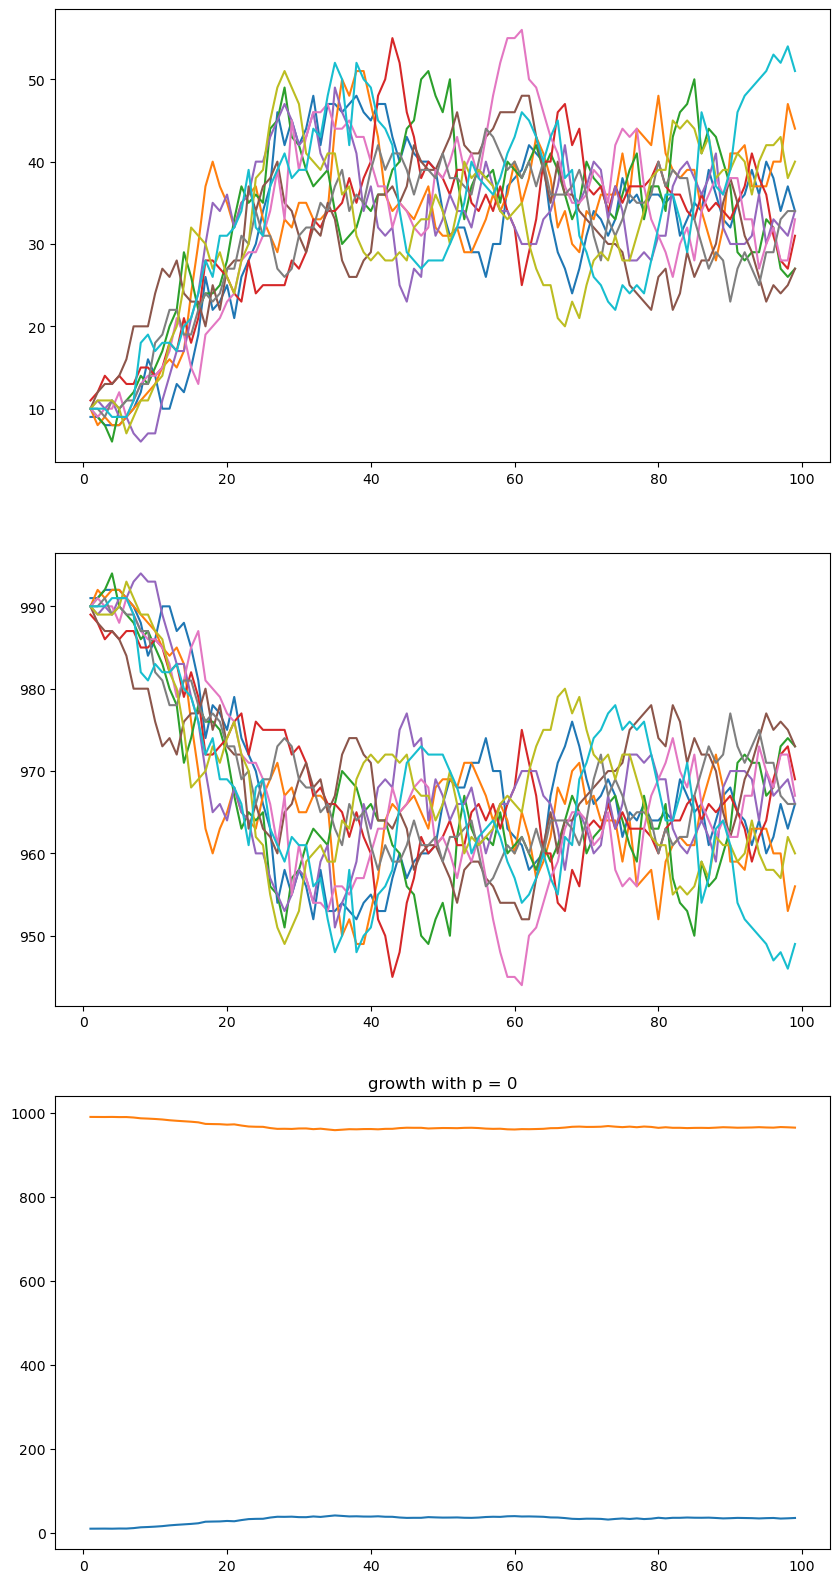

In [32]:
num_simulations = 10

fig, axs = plt.subplots(3, 1, figsize = (10, 20))

add_adop = 99 * [0]
add_unadop = 99 * [0]
#add_bore = 24 * [0]

for i in range(num_simulations):
    
    df = one_run()
    days = df.loc[:, 'days'].tolist()
    adop = df.loc[:, 'adop'].tolist()
    unadop = df.loc[:, 'unadop'].tolist()
    #bore = df.loc[:, 'bore'].tolist()
    
    axs[0].plot(days, adop)
    axs[1].plot(days, unadop)
    #axs[2].plot(days, bore)

    add_adop = [x + y for x, y in zip_longest(add_adop, adop)]
    add_unadop = [x + y for x, y in zip_longest(add_unadop, unadop)]
    #add_bore = [x + y for x, y in zip_longest(add_bore, bore)]

mon_car_adop = [i/num_simulations for i in add_adop]
mon_car_unadop = [i/num_simulations for i in add_unadop]
#mon_car_bore = [i/num_simulations for i in add_bore]
days = [i + 1 for i in range(len(mon_car_adop))]

axs[2].plot(days, mon_car_adop)
axs[2].plot(days, mon_car_unadop)
axs[2].title.set_text('growth with p = 0')
axs[2].xlabel('days')
axs[2].ylabel('people')
axs[2].legend(['adopted', 'unadopted'])
#axs[2].plot(days, mon_car_bore)